In [24]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#stopwords.words('english')

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [25]:
#!dir ..\..\1. Datasets

In [26]:
#df_tweets = pd.read_csv(r"../../1. Datasets/NLP Datasets/2. Labelled Tweets/ncr.csv")
df_tweets = pd.read_csv("ncr.csv", encoding='utf-8')

### Data Preprocessing

In [27]:
def text_to_word_list(text, tagalog_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = tagalog_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"http\S.*$"," ", text) # removing twitter urls
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", "", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        
    text = [word for word in text.split(' ') if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    return text

In [28]:
df_tweets.tweets = df_tweets.tweets.apply(lambda x: text_to_word_list(x, unidecode))

In [29]:
df_tweets.tweets

0      mayor jerry trenas representing iloilo city go...
1      online muna tayo mga kap para sa bayan sa mga ...
2      best feeling 8 hours shift covid unit removing...
3      dont forget covid 19 safety protocols us still...
4      taena nitong covid parang produkto daming vari...
                             ...                        
177    nakaka sad doctors nurses died frontliners cov...
178    dati everyday kung mag update ang doh covid re...
179    78 efficacy 100 prevention severe cases covid ...
180     kitsunemaisonn chefadobo hahahahaahaa love ko...
181    eto kabado na naman kami sa office 3 na pala c...
Name: tweets, Length: 182, dtype: object

### Vectorization

Usually splitting is done before vectorization (i.e. the vectorizer shouldn't be fitted with the test set of tweets). However, since we have a small dataset, it is more likely for words in test set to not be available in the train set (which will cause inaccuracies in the model). So in this case, let's just vectorize the full dataset before splitting.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf = TfidfVectorizer(norm=None)
tfidf.fit(df_tweets.tweets)
features = pd.Series(tfidf.get_feature_names())
X = pd.DataFrame(tfidf.transform(df_tweets.tweets).todense(), columns=features)

In [32]:
y = df_tweets.label

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
# X_train_text = X_train['tweets']
# X_val_text = X_val['tweets']

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (145, 1175)
X_val shape:  (37, 1175)
y_train shape:  (145,)
y_val shape:  (37,)


### Modeling

In [34]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
stratk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [35]:
clf = LogisticRegression()
scoring = 'accuracy'
kfold_score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(kfold_score)

[0.6        0.46666667 0.53333333 0.46666667 0.53333333 0.57142857
 0.64285714 0.35714286 0.35714286 0.5       ]


In [36]:
# kfold logistic regression score
round(np.mean(kfold_score)*100, 2)

50.29

In [37]:
from sklearn.model_selection import GridSearchCV
param_grids = {'learning_rate': [.2, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14],
              'min_samples_leaf': [2, 3, 4],
              'max_features': [.5,.3, .2] 
}   


**NOTE: This code is written a few years ago in my ML class (a bit outdated). Will try to find the updated code and update. This does manual gridsearch of hyperparameters. Actual implementation of GridSearchCV will be faster and better**

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import pandas as pd
import pylab as plot
import lmfit as lf
import seaborn as sns
import random
import os
import time
from pandas import Series
from math import sqrt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

import xgboost as XGBClassifier

import warnings
warnings.simplefilter(action='ignore')



from matplotlib import pyplot



import numpy

def classification(X, y, scaler=None):
    kneighbors = range(1, 20)
    smoothing = np.logspace(1, 15, num=10)
    a = np.logspace(-5, 5, num=10)
    gamma_list = np.logspace(-5, 5, num=10)
    depth_settings = range(1, 15)
    tolerance = np.logspace(-5, 5, num=10)
    
    knn_c = KNeighborsClassifier(n_jobs=-1)
    log_res_l1 = LogisticRegression(penalty='l1', max_iter=1000,
                             solver='liblinear', n_jobs=-1)
    log_res_l2 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    lin_svc_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    lin_svc_l2 = LinearSVC(penalty='l2', max_iter=10000)
    # cl7 = SVC(kernel='poly', degree=3)
    nsvm_rbf = SVC(kernel='rbf')
    d_tree = DecisionTreeClassifier(random_state=0, max_depth=depth_settings)
    r_forest = RandomForestClassifier(max_depth=depth_settings, random_state=0)
    xg_boost = XGBClassifier.XGBClassifier(random_state=0, max_depth=depth_settings, learning_rate=0.01)
#     mult_nb = MultinomialNB(alpha=a)
#     n_bayes = GaussianNB()
    

    est = [('KNN', knn_c, {'n_neighbors':kneighbors}),
           ('Logistic Regression (L1)', log_res_l1, {'C':a}),
           ('Logistic Regression (L2)', log_res_l2, {'C':a}),
           ('Linear SVM (L1)', lin_svc_l1, {'C':a}),
           ('Linear SVM (L2)', lin_svc_l2, {'C':a}),
           ('NonLinear SVM (RBF)', nsvm_rbf, {'C':a, 'gamma':gamma_list}),
           ('Decision Tree',d_tree,{'max_depth':depth_settings}),
           ('Random Forest',r_forest,{'max_depth':depth_settings}),
           ('XGBoost',xg_boost,{'max_depth':depth_settings})]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    
    if scaler == 'ss':
        scale = StandardScaler()
        X_train = scale.fit_transform(X = X_train)
        X_val = scale.transform(X = X_val)
    elif scaler == 'mm':
        scale = MinMaxScaler()
        X_train = scale.fit_transform(X_train)
        X_val = scale.transform(X_val)
    else:
        pass
    
    models = {}
    for e in est:
        print(f'Training {e[0]}')
        start_time = time.time()
        gs_cv = GridSearchCV(e[1], param_grid=e[2], n_jobs=-1)
        gs_cv.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        models[e[0]] = gs_cv, elapsed_time
        print(f'Training {e[0]} complete in {elapsed_time} seconds \n')
    
    accuracy_summary ={}
    for m in models:
        test_acc = models[m][0].best_estimator_.score(X_val, y_val)
        train_acc = models[m][0].best_estimator_.score(X_train, y_train)
        best_param = models[m][0].best_params_
        accuracy_summary[m] = test_acc, train_acc, best_param, models[m][1]
    
    target_count = np.unique(y, return_counts=True)[1]
    pcc = np.sum((target_count/target_count.sum())**2)
        
    results_summary = pd.DataFrame.from_dict(accuracy_summary, orient='index', columns=['Test Accuracy', 'Training Accuracy', 'Best Parameters', 'Run Time'])
    results_summary['Test Accuracy / PCC'] = results_summary['Test Accuracy']/pcc
    
    #linear
    summary={}
    methods_l = ['Logistic Regression (L1)','Logistic Regression (L2)',
              'Linear SVM (L1)','Linear SVM (L2)']

    for m in methods_l:
        pred = []
        for i,j in list(zip(X.columns, (models[m][0].best_estimator_.coef_))):
            pred.append([i,j[np.abs(j).argmax()]])
            summary[m] = pred

    #ensamble
    methods_e = ['Decision Tree', 'Random Forest','XGBoost']
    pred = []
    for m in methods_e:
        coefs = [(X.columns[(models[m][0].best_estimator_.feature_importances_).argsort()[-3:]
                           ], models[m][0].best_estimator_.feature_importances_[
            (models[m][0].best_estimator_.feature_importances_).argsort()[-3:]])]

        coeff = list(zip(*coefs[0]))
        pred.append(coeff)
        summary[m] = pred[0]

    #no coeff
    methods_no = ['KNN','NonLinear SVM (RBF)']
    for m in methods_no:
        summary[m] = [[np.nan],[np.nan],[np.nan]]

    df_summary_c1 = pd.DataFrame.from_dict(summary)
        
    return results_summary.join(df_summary_c1.T, how='left')

In [51]:
model_performances = classification(X,y,scaler=None)

Training KNN
Training KNN complete in 4.638301372528076 seconds 

Training Logistic Regression (L1)
Training Logistic Regression (L1) complete in 0.8062481880187988 seconds 

Training Logistic Regression (L2)
Training Logistic Regression (L2) complete in 2.1716747283935547 seconds 

Training Linear SVM (L1)
Training Linear SVM (L1) complete in 3.2298083305358887 seconds 

Training Linear SVM (L2)
Training Linear SVM (L2) complete in 0.868689775466919 seconds 

Training NonLinear SVM (RBF)
Training NonLinear SVM (RBF) complete in 11.626434326171875 seconds 

Training Decision Tree
Training Decision Tree complete in 1.0874981880187988 seconds 

Training Random Forest
Training Random Forest complete in 7.377640962600708 seconds 

Training XGBoost
Training XGBoost complete in 65.94825005531311 seconds 



In [52]:
model_performances

,Test Accuracy,Training Accuracy,Best Parameters,Run Time,Test Accuracy / PCC,0,1,2
KNN,0.540541,0.724138,{'n_neighbors': 12},4.638301,1.418544,[nan],[nan],[nan]
Logistic Regression (L1),0.621622,0.862069,{'C': 0.2782559402207126},0.806248,1.631326,"[000, 0.3943897028169658]","[10, -0.710828787650146]","[100, -0.6794881387204452]"
Logistic Regression (L2),0.621622,0.972414,{'C': 0.021544346900318846},2.171675,1.631326,"[000, 0.0898000780119623]","[10, 0.07249670803438732]","[100, 0.1105365630480242]"
Linear SVM (L1),0.648649,1.000000,{'C': 3.593813663804626},3.229808,1.702253,"[000, 0.9335408437389131]","[10, -1.3446957977410057]","[100, 0.46191392052260766]"
Linear SVM (L2),0.648649,0.972414,{'C': 0.0016681005372000592},0.868690,1.702253,"[000, -0.03815140571885928]","[10, -0.07445835664585077]","[100, -0.06556584699866412]"
NonLinear SVM (RBF),0.621622,0.979310,"{'C': 599.4842503189421, 'gamma': 1e-05}",11.626434,1.631326,[nan],[nan],[nan]
Decision Tree,0.540541,0.613793,{'max_depth': 2},1.087498,1.418544,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)"
Random Forest,0.540541,0.751724,{'max_depth': 14},7.377641,1.418544,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)"
XGBoost,0.675676,0.737931,{'max_depth': 5},65.948250,1.773180,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)"


In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier

knn_c = KNeighborsClassifier(n_jobs=-1)
log_res_l1 = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', n_jobs=-1)
log_res_l2 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
lin_svc_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
lin_svc_l2 = LinearSVC(penalty='l2', max_iter=10000)
# cl7 = SVC(kernel='poly', degree=3)
depth_settings = range(1, 15)
nsvm_rbf = SVC(kernel='rbf')
d_tree = DecisionTreeClassifier(random_state=0, max_depth=depth_settings)
r_forest = RandomForestClassifier(max_depth=depth_settings, random_state=0)
xg_boost = XGBClassifier.XGBClassifier(random_state=0, max_depth=depth_settings, learning_rate=0.01)

model_list = [knn_c, log_res_l1, log_res_l2, lin_svc_l1, lin_svc_l2, nsvm_rbf, d_tree, r_forest, xg_boost]
model_dict = {}

f1_scores_micro = []
f1_scores_macro = []
f1_scores_weighted = []

precision_scores_micro = []
precision_scores_macro = []
precision_scores_weighted = []

recall_scores_micro = []
recall_scores_macro = []
recall_scores_weighted = []

counter = 0
model_predict_df = pd.DataFrame()
for index, row in model_performances.iterrows():
    model_dict[index] = model_list[counter]
    curr_model = model_list[counter]
    print(curr_model)
    curr_model.set_params(**row['Best Parameters'])
    trained_curr_model = curr_model.fit(X_train, y_train)
    predictions = trained_curr_model.predict(X_val)
    
    f1_scores_micro.append(f1_score(predictions, y_val, average='micro'))
    f1_scores_macro.append(f1_score(predictions, y_val, average='macro'))
    f1_scores_weighted.append(f1_score(predictions, y_val, average='weighted'))
    
    precision_scores_micro.append(precision_score(predictions, y_val, average='micro'))
    precision_scores_macro.append(precision_score(predictions, y_val, average='macro'))
    precision_scores_weighted.append(precision_score(predictions, y_val, average='weighted'))
    
    recall_scores_micro.append(recall_score(predictions, y_val, average='micro'))
    recall_scores_macro.append(recall_score(predictions, y_val, average='macro'))
    recall_scores_weighted.append(recall_score(predictions, y_val, average='weighted'))
    
    model_predict_df[index] = predictions
    counter += 1

KNeighborsClassifier(n_jobs=-1)
LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', solver='liblinear')
LogisticRegression(max_iter=1000, n_jobs=-1)
LinearSVC(dual=False, max_iter=10000, penalty='l1')
LinearSVC(max_iter=10000)
SVC()
DecisionTreeClassifier(max_depth=range(1, 15), random_state=0)
RandomForestClassifier(max_depth=range(1, 15), random_state=0)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=range(1, 15),
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=Non

In [57]:
model_performances['F1 Score Micro'] = f1_scores_micro
model_performances['F1 Score Macro'] = f1_scores_macro
model_performances['F1 Score Weighted'] = f1_scores_weighted

model_performances['Recall Score Micro'] = recall_scores_micro
model_performances['Recall Score Macro'] = recall_scores_macro
model_performances['Recall Score Weighted'] = recall_scores_weighted

model_performances['Precision Score Micro'] = precision_scores_micro
model_performances['Precision Score Macro'] = precision_scores_macro
model_performances['Precision Score Weighted'] = precision_scores_weighted

In [58]:
model_performances

,Test Accuracy,Training Accuracy,Best Parameters,Run Time,Test Accuracy / PCC,0,1,2,F1 Score Micro,F1 Score Macro,F1 Score Weighted,Recall Score Micro,Recall Score Macro,Recall Score Weighted,Precision Score Micro,Precision Score Macro,Precision Score Weighted
KNN,0.540541,0.724138,{'n_neighbors': 12},4.638301,1.418544,[nan],[nan],[nan],0.540541,0.328979,0.649119,0.540541,0.398693,0.540541,0.540541,0.382456,0.886771
Logistic Regression (L1),0.621622,0.862069,{'C': 0.2782559402207126},0.806248,1.631326,"[000, 0.3943897028169658]","[10, -0.710828787650146]","[100, -0.6794881387204452]",0.621622,0.515058,0.670149,0.621622,0.749104,0.621622,0.621622,0.499123,0.838336
Logistic Regression (L2),0.621622,0.972414,{'C': 0.021544346900318846},2.171675,1.631326,"[000, 0.0898000780119623]","[10, 0.07249670803438732]","[100, 0.1105365630480242]",0.621622,0.516190,0.671197,0.621622,0.776882,0.621622,0.621622,0.499123,0.839687
Linear SVM (L1),0.648649,1.000000,{'C': 3.593813663804626},3.229808,1.702253,"[000, 0.9335408437389131]","[10, -1.3446957977410057]","[100, 0.46191392052260766]",0.648649,0.603175,0.670528,0.648649,0.667391,0.648649,0.648649,0.613158,0.725889
Linear SVM (L2),0.648649,0.972414,{'C': 0.0016681005372000592},0.868690,1.702253,"[000, -0.03815140571885928]","[10, -0.07445835664585077]","[100, -0.06556584699866412]",0.648649,0.550000,0.690541,0.648649,0.762452,0.648649,0.648649,0.532456,0.820910
NonLinear SVM (RBF),0.621622,0.979310,"{'C': 599.4842503189421, 'gamma': 1e-05}",11.626434,1.631326,[nan],[nan],[nan],0.621622,0.516190,0.671197,0.621622,0.776882,0.621622,0.621622,0.499123,0.839687
Decision Tree,0.540541,0.613793,{'max_depth': 2},1.087498,1.418544,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)",0.540541,0.347222,0.627252,0.540541,0.320402,0.540541,0.540541,0.398246,0.766145
Random Forest,0.540541,0.751724,{'max_depth': 14},7.377641,1.418544,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)",0.540541,0.328979,0.649119,0.540541,0.398693,0.540541,0.540541,0.382456,0.886771
XGBoost,0.675676,0.737931,{'max_depth': 5},65.948250,1.773180,"(lgus, 0.2303345402528252)","(por, 0.25671081977659505)","(covid, 0.5129546399705798)",0.675676,0.594203,0.710089,0.675676,0.694444,0.675676,0.675676,0.582456,0.804836


In [59]:
model_predict_df

,KNN,Logistic Regression (L1),Logistic Regression (L2),Linear SVM (L1),Linear SVM (L2),NonLinear SVM (RBF),Decision Tree,Random Forest,XGBoost
0,-1,-1,-1,-1,1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,0,-1,-1,1,-1,0
5,-1,-1,-1,0,-1,-1,-1,-1,-1
6,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,-1,-1,-1,0,1,-1,-1,-1,-1
8,-1,-1,-1,0,-1,-1,1,-1,-1
9,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [22]:
model_predict_df.to_csv('all_model_predictions.csv')

In [23]:
model_performances = pd.read_csv('model_performances.csv')
model_performances_copy = model_performances.copy()
model_performances_copy.rename(columns={'Unnamed: 0': 'Algorithms'}, inplace=True)
model_performances_copy.head()

,Algorithms,Algorithms,Test Accuracy,Training Accuracy,Best Parameters,Run Time,percent of PCC,0,1,2,...,F1 Score Macro,F1 Score Weighted,Recall Score,Precision Score,Recall Score Micro,Recall Score Macro,Recall Score Weighted,Precision Score Micro,Precision Score Macro,Precision Score Weighted
0,0,KNN,0.513514,0.586207,{'n_neighbors': 11},1.309995,1.347617,[nan],[nan],[nan],...,0.226190,0.678571,0.513514,1.000000,0.513514,0.171171,0.513514,0.513514,0.333333,1.000000
1,1,Logistic Regression (L1),0.621622,1.000000,{'C': 599.4842503189421},3.868001,1.631326,"['000', -1.2262577545315585]","['0a08dwsjty', -2.8805869509602426]","['0wzxb3n4j9', -2.7253698076951407]",...,0.569573,0.686256,0.621622,0.756152,0.648649,0.783333,0.648649,0.648649,0.540789,0.830974
2,2,Logistic Regression (L2),0.648649,1.000000,{'C': 0.2782559402207126},2.160705,1.702253,"['000', -0.16885605165841644]","['0a08dwsjty', 0.2817473148696053]","['0wzxb3n4j9', 0.24544967884729332]",...,0.559524,0.688224,0.648649,0.815505,0.648649,0.706897,0.648649,0.648649,0.540789,0.815505
3,3,Linear SVM (L1),0.648649,1.000000,{'C': 0.2782559402207126},1.866419,1.702253,"['000', 0.46233130606259887]","['0a08dwsjty', 0.350727918862724]","['0wzxb3n4j9', 0.37312739526826555]",...,0.555319,0.687752,0.648649,0.798009,0.648649,0.664286,0.648649,0.648649,0.540789,0.798009
4,4,Linear SVM (L2),0.648649,1.000000,{'C': 0.0016681005372000592},0.543514,1.702253,"['000', -0.04141675364049047]","['0a08dwsjty', -0.06455537526105888]","['0wzxb3n4j9', -0.05927501040747649]",...,0.552536,0.685958,0.648649,0.780512,0.648649,0.638889,0.648649,0.648649,0.540789,0.780512


In [24]:
model_performances_copy.to_csv('model_performances.csv')

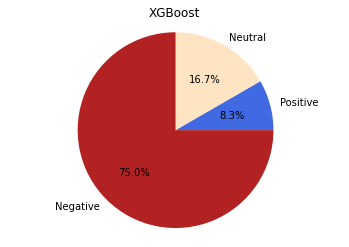

In [61]:
import matplotlib.pyplot as plt

Numbers = [3,6,27]

my_labels = 'Positive','Neutral','Negative'
colors = ["royalblue", "bisque", "firebrick"]
plt.pie(Numbers,labels=my_labels,autopct='%1.1f%%', colors=colors)
plt.title('XGBoost')
plt.axis('equal')
plt.show()